<a href="https://colab.research.google.com/github/xsinxxer/starters/blob/main/explainable_ai_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240513%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240513T130447Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7f14e9960d266f4511995d5a7b497a185d88e8f72f00030bb4f392c3952fde60ebce2f2b3dfed25afe733b5b26684b37a9f30eea5e49a442aa82639fd3197f3eeaad70f75ac4db0421c6e881f11f3cc309f0160299a18f7c8f187b27530b75a7ce19a67ebf02eda5e4eb945a89ad25cb2a8c80ee816fa690c3c68a8f5e629948fd3d1c3bff98aa8a1dd47cc01e42edb3dd263b829f2981f24c61c8e4c4a355abbfa0e1a7e9eb41ee74c94bb6f87ba120ab9c885d8bd108a669a5e2f16f3fa4a30e03aa52bbc8a660d84a414e2889383c4cf8ec61e1ca012269eb06944306ffeb8157da262bcaad133c69ff38147ab765aa0758c4ce7b3ace85cbb861706144ca'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


# Importing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#.pyplot
from scipy.ndimage import rotate
import tensorflow as tf
from tensorflow import keras
from keras import layers,models#layers and models from keras
from sklearn.model_selection import train_test_split#sklearn.model_selectiom for split
from tensorflow.keras.models import Sequential#sequential not from keras but from "models"
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Conv1D, DepthwiseConv1D, Flatten, Dense#conv1d and 2d..depthwise..fromm tf mention
from sklearn.metrics import confusion_matrix#metrics of sklearn
from tensorflow.keras.layers import BatchNormalization#tf - batchnormalization
from tensorflow.keras.layers import BatchNormalization, LeakyReLU


# Reading dataframe

In [4]:
dftr = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')#pd.   ; path
dfte = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [5]:
natr = dftr.values
nate = dfte.values
labels_tr = np.zeros(42000)#zeros
data_tr = np.zeros(42000*784)
data_tr = data_tr.reshape(42000,28,28)
counter = 0
for x in natr:
    labels_tr[counter] = x[0]
    data_tr[counter] = x[1:].reshape(28,28)#1:
    counter = counter + 1
print(data_tr[0])

#print(natr[0][1:].reshape(28,28))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0. 188. 255.  94.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0. 191. 250. 253.  93.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0. 123. 248. 253. 167.  10.   0.   0.  

# Normalizing

In [6]:
datr_ = data_tr/255#directly!!!
print(datr_.shape)

(42000, 28, 28)


In [7]:
#shuffle!!!
labels = np.zeros(datr_.shape[0])
print(labels.shape)
counter = 0
for y in labels_tr:
    labels[counter] = y
    #labels[counter+1] = y
    #labels[counter+2] = y
    counter = counter + 1

(42000,)


In [8]:
from sklearn.model_selection import train_test_split
xtr, xte, ytr, yte = train_test_split(datr_,labels, test_size=0.2, random_state=42)#xtr then xte

In [9]:
xtr = np.array(xtr)
xte = np.array(xte)
print(xte.shape)
xtr = xtr.reshape(33600,784)
xte = xte.reshape(8400,784)

(8400, 28, 28)


# Our first basic ANN Model

In [10]:
from keras.layers import BatchNormalization,Dropout
model = models.Sequential([
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(xtr, ytr, epochs=5, batch_size=128,validation_data = (xte,yte))


Epoch 1/5
263/263 [==============================] - 5s 15ms/step - loss: 0.8753 - accuracy: 0.7806 - val_loss: 0.4968 - val_accuracy: 0.8779
Epoch 2/5
263/263 [==============================] - 3s 11ms/step - loss: 0.4416 - accuracy: 0.8833 - val_loss: 0.3906 - val_accuracy: 0.8977
Epoch 3/5
263/263 [==============================] - 2s 8ms/step - loss: 0.3744 - accuracy: 0.8977 - val_loss: 0.3529 - val_accuracy: 0.9051
Epoch 4/5
263/263 [==============================] - 2s 8ms/step - loss: 0.3430 - accuracy: 0.9045 - val_loss: 0.3333 - val_accuracy: 0.9077
Epoch 5/5
263/263 [==============================] - 1s 4ms/step - loss: 0.3248 - accuracy: 0.9084 - val_loss: 0.3182 - val_accuracy: 0.9127


# Below is the visualisation

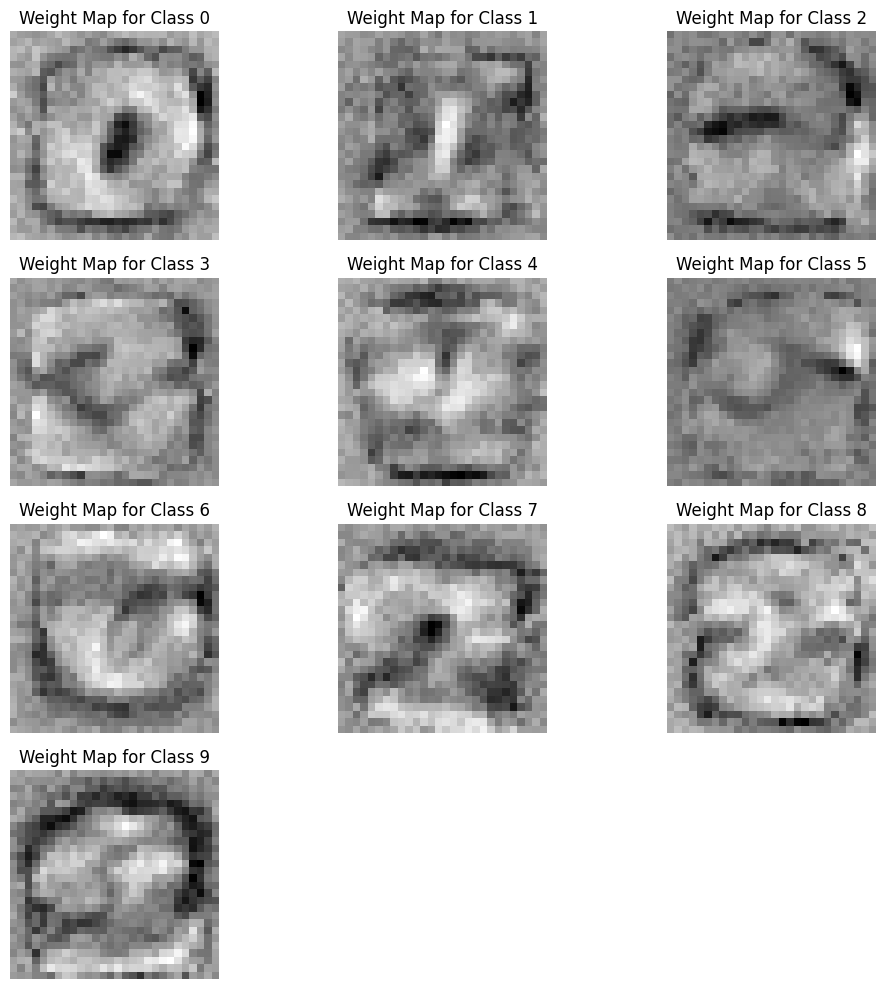

In [12]:
import matplotlib.pyplot as plt
import numpy as np
weights = model.layers[1].get_weights()[0]
#weights_sigmoid = 1 / (1 + np.exp(-weights))
weights_map = weights.reshape((28, 28, 10))
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(4, 3, i+1)
    plt.imshow(weights_map[:, :, i], cmap='gray')
    plt.title(f'Weight Map for Class {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# using relu

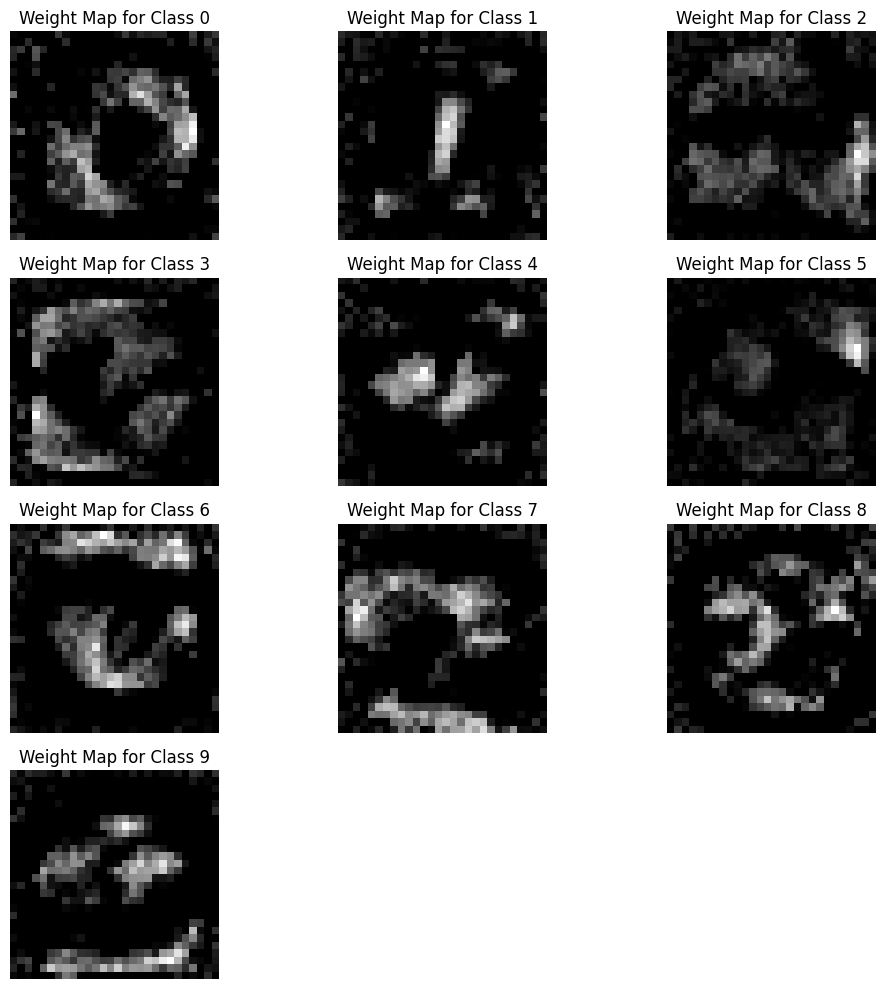

In [13]:
import matplotlib.pyplot as plt
import numpy as np
weights = model.layers[1].get_weights()[0]
weights_relu = np.maximum(0, weights)
weights_map = weights_relu.reshape((28, 28, 10))
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(4, 3, i+1)
    plt.imshow(weights_map[:, :, i], cmap='gray')
    plt.title(f'Weight Map for Class {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# now using sigmoid

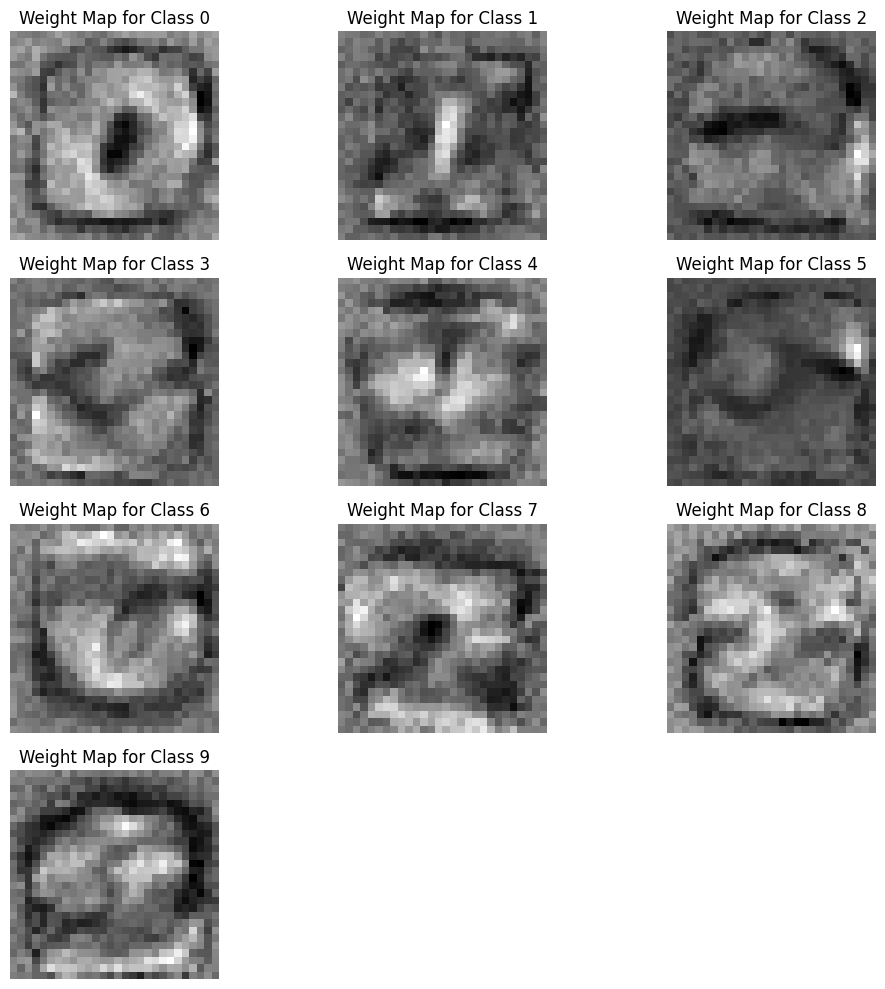

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get the weights of the Dense layer
weights = model.layers[1].get_weights()[0]

# softmax activation to the weights
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

weights_softmax = softmax(weights)
weights_map = weights_softmax.reshape((28, 28, 10))
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(4, 3, i+1)
    plt.imshow(weights_map[:, :, i], cmap='gray')
    plt.title(f'Weight Map for Class {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# visualising distribution of weights

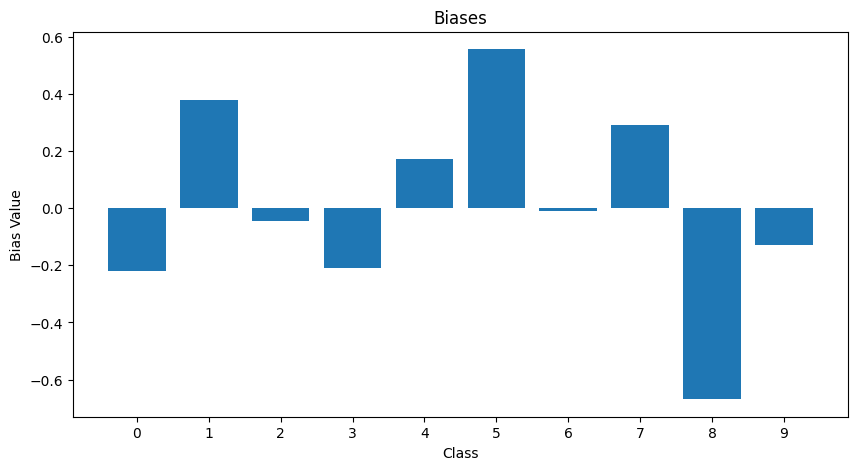

In [15]:
import matplotlib.pyplot as plt
import numpy as np
weights, biases = model.layers[1].get_weights()
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), biases)
plt.title('Biases')
plt.xlabel('Class')
plt.ylabel('Bias Value')
plt.xticks(np.arange(10))
plt.show()


#An attempt at understanding multi layered ANN which terribly failed

In [17]:
from keras.layers import BatchNormalization,Dropout
model = models.Sequential([
    layers.Dense(84, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(xtr, ytr, epochs=3, batch_size=128,validation_data = (xte,yte))


Epoch 1/3
263/263 [==============================] - 4s 13ms/step - loss: 0.5375 - accuracy: 0.8509 - val_loss: 0.2808 - val_accuracy: 0.9232
Epoch 2/3
263/263 [==============================] - 3s 10ms/step - loss: 0.2525 - accuracy: 0.9287 - val_loss: 0.2139 - val_accuracy: 0.9404
Epoch 3/3
263/263 [==============================] - 1s 6ms/step - loss: 0.1934 - accuracy: 0.9451 - val_loss: 0.1791 - val_accuracy: 0.9514


# understanding below image through our model

8.0


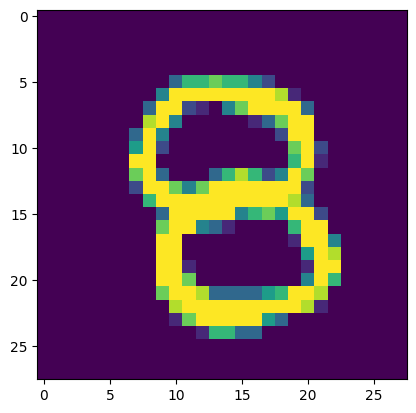

In [18]:
print(ytr[5])
plt.imshow(xtr[5].reshape(28,28))

# an absolute mess

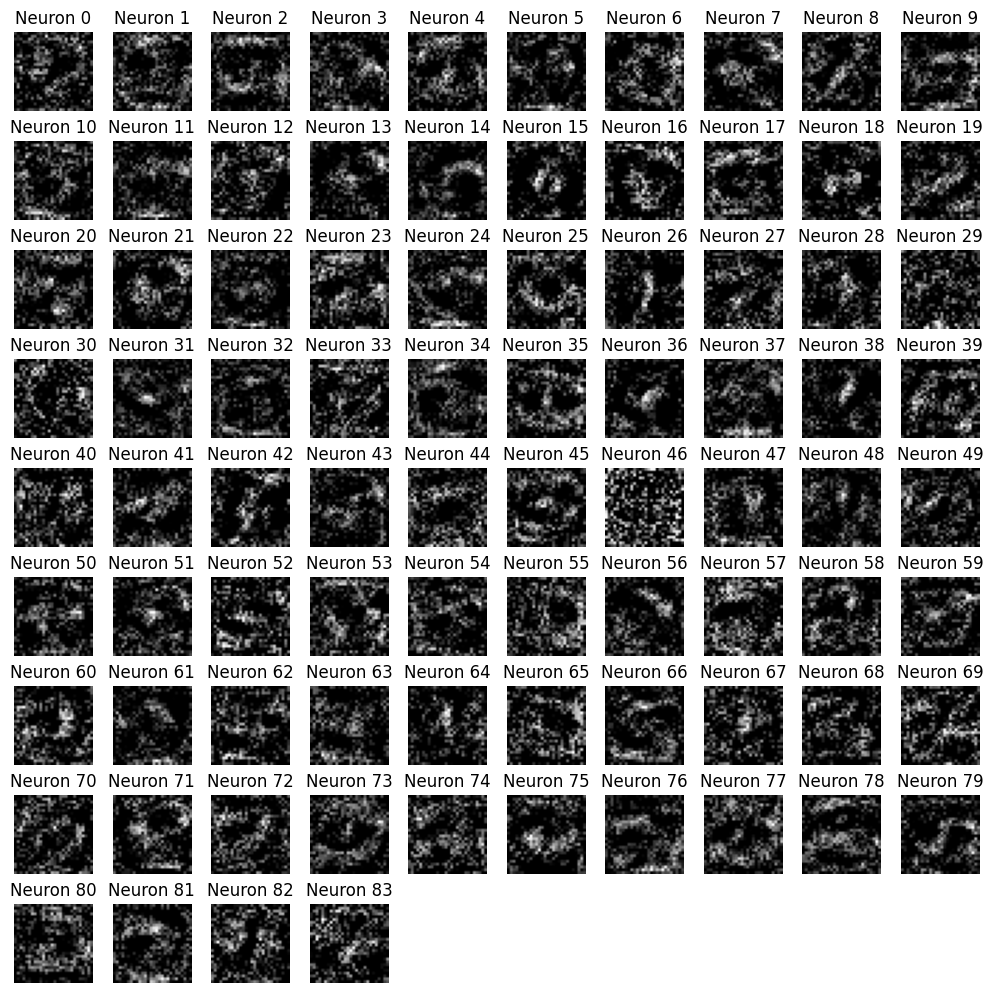

In [19]:
import matplotlib.pyplot as plt
import numpy as np
weights_layer1 = model.layers[0].get_weights()[0]
weights_relu_layer1 = np.maximum(0, weights_layer1)
weights_map_layer1 = weights_relu_layer1.reshape((28, 28, 84))
plt.figure(figsize=(10, 10))
for i in range(84):
    plt.subplot(9, 10, i+1)
    plt.imshow(weights_map_layer1[:, :, i], cmap='gray')
    plt.title(f'Neuron {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()
weights_layer2 = model.layers[2].get_weights()[0]
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
weights_softmax_layer2 = softmax(weights_layer2)
weights_map_layer2 = weights_softmax_layer2.reshape((84, 10))
plt.show()

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
xtr_reshaped = xtr.reshape(-1, 28, 28, 1)
xte_reshaped = xte.reshape(-1, 28, 28, 1)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtr_reshaped, ytr, epochs=5, batch_size=128, validation_data=(xte_reshaped, yte))

Epoch 1/5
263/263 [==============================] - 11s 41ms/step - loss: 0.3515 - accuracy: 0.9026 - val_loss: 0.1795 - val_accuracy: 0.9501
Epoch 2/5
263/263 [==============================] - 9s 36ms/step - loss: 0.1275 - accuracy: 0.9646 - val_loss: 0.1084 - val_accuracy: 0.9687
Epoch 3/5
263/263 [==============================] - 10s 39ms/step - loss: 0.0794 - accuracy: 0.9782 - val_loss: 0.0847 - val_accuracy: 0.9755
Epoch 4/5
263/263 [==============================] - 12s 45ms/step - loss: 0.0585 - accuracy: 0.9832 - val_loss: 0.0768 - val_accuracy: 0.9770
Epoch 5/5
263/263 [==============================] - 13s 48ms/step - loss: 0.0448 - accuracy: 0.9874 - val_loss: 0.0707 - val_accuracy: 0.9785


# guessing maybe the kernel(*1st of our 32 kernels defined*) below helps is identifying a "*straight diagonal line*" of any 3*3 grid in the image

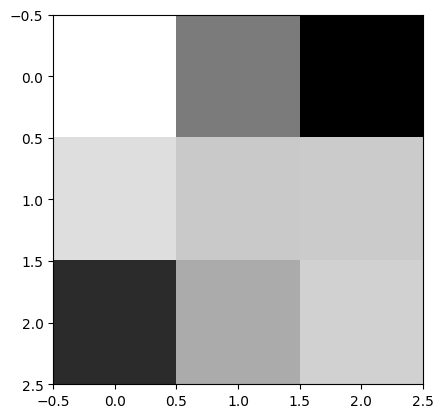

In [26]:
x = model.layers[0].get_weights()[0]
plt.imshow(x[:,:,0,0],cmap = 'gray')

In [27]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, Dense, Input
import matplotlib.pyplot as plt
input_layer = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
conv2 = Conv2D(32, (3, 3), activation='relu')(conv1)
conv3 = Conv2D(32, (3, 3), activation='relu')(conv2)
flatten_layer = Flatten()(conv3)
output_layer = Dense(10, activation='softmax')(flatten_layer)
model = Model(inputs=input_layer, outputs=output_layer)#cant use model.input for some reason maybe because never called
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtr_reshaped, ytr, epochs=1, batch_size=128, validation_data=(xte_reshaped, yte))

conv_output_models = [Model(inputs=input_layer, outputs=layer) for layer in [conv1, conv2, conv3]]

263/263 [==============================] - 82s 306ms/step - loss: 0.2562 - accuracy: 0.9246 - val_loss: 0.1075 - val_accuracy: 0.9689


1/1 [==============================] - 0s 314ms/step


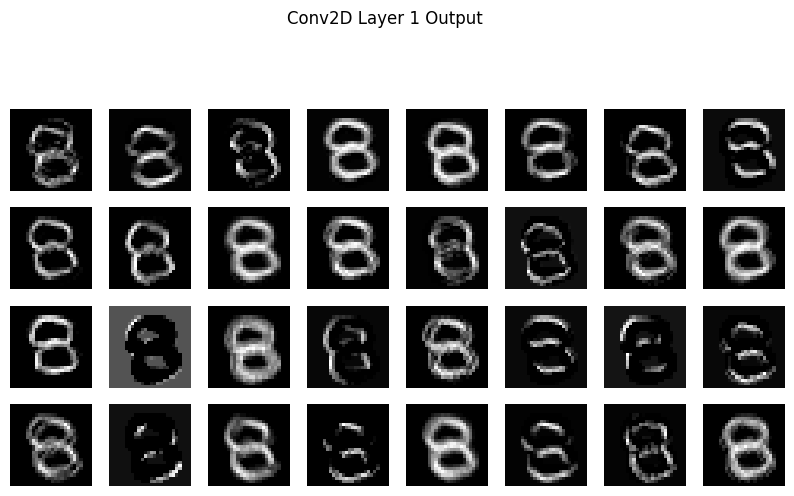

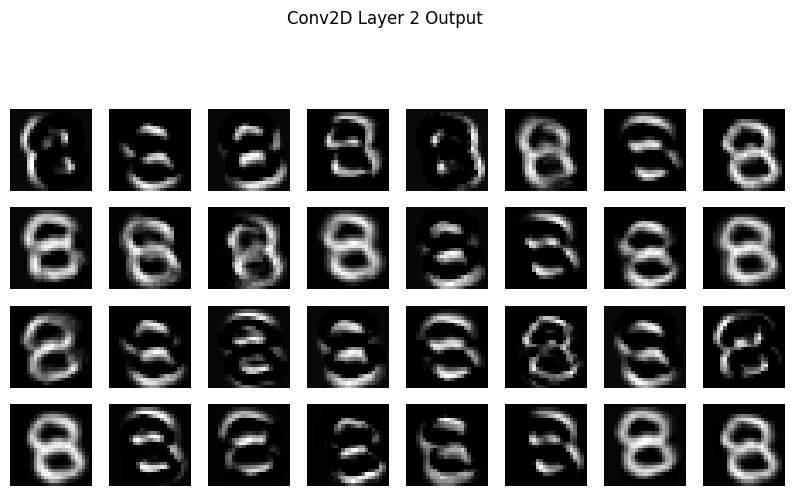

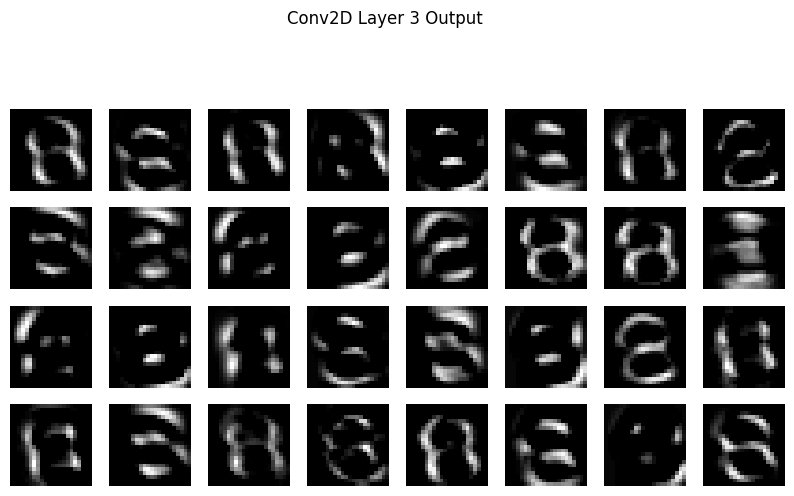

In [28]:
conv_outputs = [conv_output_model.predict(xtr_reshaped[5:6]) for conv_output_model in conv_output_models]
for i, conv_output in enumerate(conv_outputs):
    plt.figure(figsize=(10, 10))
    for j in range(conv_output.shape[-1]):  # Get the number of channels
        plt.subplot(8, 8, j+1)#subplot size out of plot dimesnion - 8,8 each and increment by j inside 10,10 then outside 2 dimesnion - 10,10
        plt.imshow(conv_output[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Conv2D Layer {i+1} Output')
    plt.show()


# We see above later layers capture intricate details while earlier details capture the image as a whole

note that it does so automatically as kernel size is kept same in all 3 layers
we can better capture intricate details both at start and at end through parellel networks

# Since each kernel is size 3*3 ,its only capable to capture edges not lines or curves here

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(xtr)
transformed_data_pca = pca.transform(xtr)

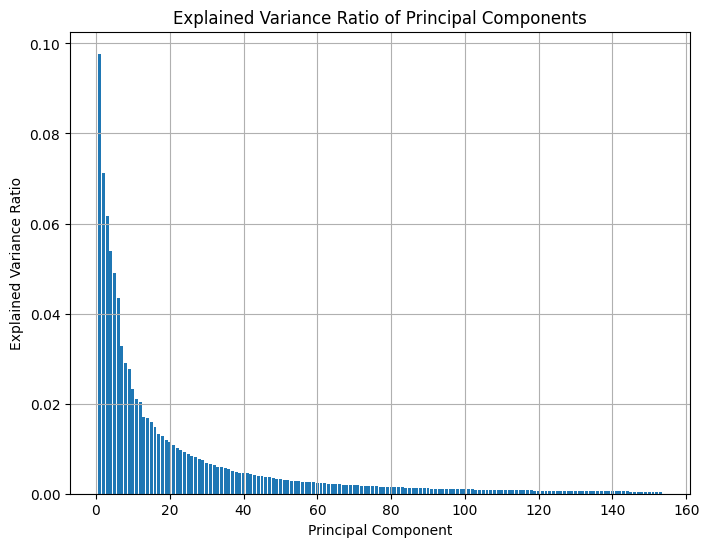

"\ncomponents = pca.components_\n\nplt.figure(figsize=(12, 8))\nfor i, component in enumerate(components):\n    plt.subplot(3, 4, i + 1)\n    plt.imshow(component.reshape(28, 28), cmap='viridis')\n    plt.title('Component {}'.format(i + 1))\n    plt.axis('off')\nplt.suptitle('Visualizing Components')\nplt.show()\n"

In [30]:
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center')
plt.title('Explained Variance Ratio of Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()
"""
components = pca.components_

plt.figure(figsize=(12, 8))
for i, component in enumerate(components):
    plt.subplot(3, 4, i + 1)
    plt.imshow(component.reshape(28, 28), cmap='viridis')
    plt.title('Component {}'.format(i + 1))
    plt.axis('off')
plt.suptitle('Visualizing Components')
plt.show()
"""

# Below visualised components represents direction/vector/images of maximum variance

ValueError: num must be an integer with 1 <= num <= 12, not 13

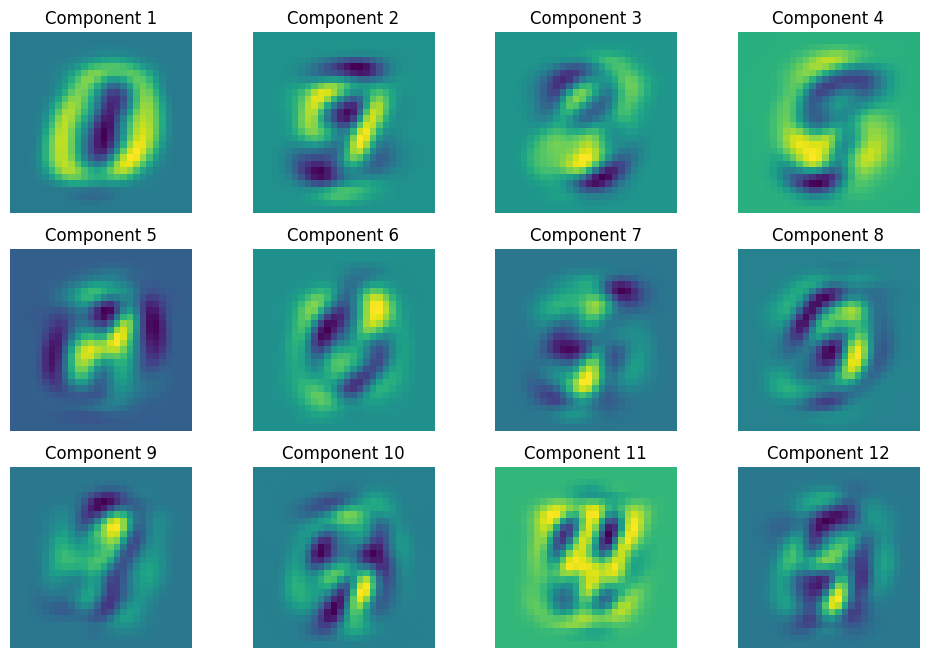

In [31]:
components = pca.components_

plt.figure(figsize=(12, 8))
for i, component in enumerate(components):
    plt.subplot(3, 4, i+1)
    plt.imshow(component.reshape(28, 28), cmap='viridis')
    plt.title('Component {}'.format(i + 1))
    plt.axis('off')
plt.suptitle('Visualizing Components')
plt.show()

In [33]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
xtr_pca = pca.fit_transform(xtr.reshape(xtr.shape[0], -1))
fig = go.Figure(data=[go.Scatter3d(
    x=xtr_pca[:, 0],
    y=xtr_pca[:, 1],
    z=xtr_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=ytr,
        colorscale='Viridis',
        opacity=0.8
    )
)])
fig.update_layout(
    title='Transformed xtr with Labels as Colors (3D)',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    )
)
fig.show()


#                We can see- though closer labels get placed closer; but still not that clear for an unsupervised learning!
soon we will use t sne and lda to plot

In [34]:
import plotly.graph_objects as go
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=3)
xtr_lda = lda.fit_transform(xtr.reshape(xtr.shape[0], -1), ytr)
fig = go.Figure(data=[go.Scatter3d(
    x=xtr_lda[:, 0],
    y=xtr_lda[:, 1],
    z=xtr_lda[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=ytr,  # Assuming ytr contains class labels
        colorscale='Viridis',
        opacity=0.8
    )
)])
fig.update_layout(
    title='Transformed xtr with Labels as Colors (3D)',
    scene=dict(
        xaxis=dict(title='LD 1'),
        yaxis=dict(title='LD 2'),
        zaxis=dict(title='LD 3')
    )
)
fig.show()

In [ ]:
#below is when i used qda to test accuracy
from sklearn.metrics import accuracy_score
y_pred = qda.predict(xtr.reshape(xtr.shape[0], -1))
accuracy = accuracy_score(ytr, y_pred)
print("Accuracy:", accuracy)

just wow lol..61% fuck it

# Lets understand how lstm evaluates

taking 28 rows as features and 28 columns as time steps for our lstm

In [35]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
xtr = xtr.reshape(33600,28,28)
xte = xte.reshape(8400,28,28)
model = Sequential([
    LSTM(128,input_shape=(28, 28)),
    Dense(10, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xtr,ytr, batch_size=128, epochs=5, validation_split=0.2)
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/5
210/210 [==============================] - 19s 84ms/step - loss: 0.8137 - accuracy: 0.7303 - val_loss: 0.3190 - val_accuracy: 0.9001
Epoch 2/5
210/210 [==============================] - 17s 81ms/step - loss: 0.2383 - accuracy: 0.9259 - val_loss: 0.1942 - val_accuracy: 0.9448
Epoch 3/5
210/210 [==============================] - 19s 90ms/step - loss: 0.1627 - accuracy: 0.9490 - val_loss: 0.1569 - val_accuracy: 0.9540
Epoch 4/5
210/210 [==============================] - 18s 87ms/step - loss: 0.1212 - accuracy: 0.9622 - val_loss: 0.1326 - val_accuracy: 0.9591
Epoch 5/5
210/210 [==============================] - 17s 82ms/step - loss: 0.0987 - accuracy: 0.9692 - val_loss: 0.1124 - val_accuracy: 0.9667


NameError: name 'x_test' is not defined

# What you see is how the model gets sure of output as it goes through different rows of input one by one

In [45]:

# Now for prediction
for counter in range(28):
    tc = xtr[0]
    # Reshaping tc to match the model's input shape
    tc = tc[:counter+1, :].reshape(1, counter+1, 28)
    # Performing prediction
    print(np.argmax(model.predict(tc, verbose=0)))

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 28, 28), found shape=(None, 1, 28)


#Which features matter most in decion tree??

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier()
model.fit(xte.reshape(8400,784), yte)
predictions = model.predict(xte.reshape(8400,784))
accuracy = accuracy_score(yte, predictions)
print("Accuracy:", accuracy)


Accuracy: 1.0


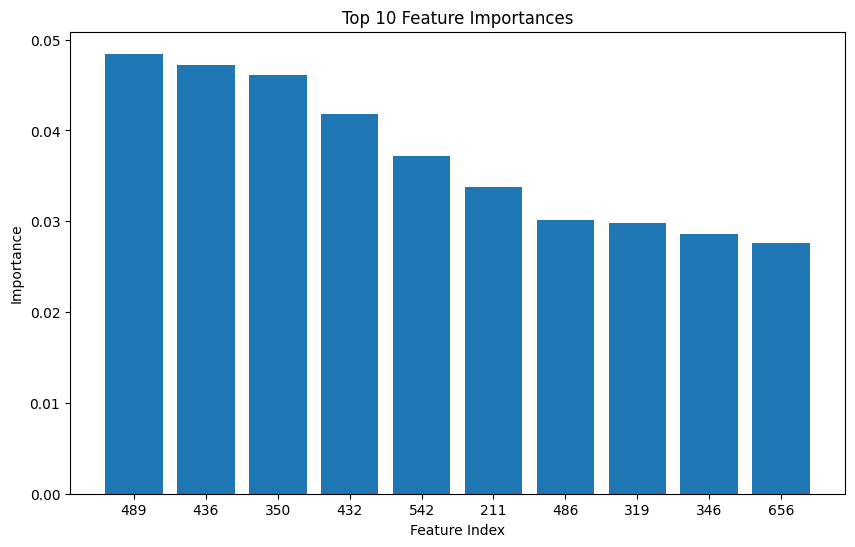

Top 10 Features and their Importances:
Feature 489: Importance = 0.04844470732792566
Feature 436: Importance = 0.0471608948716538
Feature 350: Importance = 0.046121668916493684
Feature 432: Importance = 0.04177607477927462
Feature 542: Importance = 0.037159949489208956
Feature 211: Importance = 0.03379679628098275
Feature 486: Importance = 0.030087591675813347
Feature 319: Importance = 0.029795350948990256
Feature 346: Importance = 0.02863745387920668
Feature 656: Importance = 0.02758258547070333


In [55]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
plt.figure(figsize=(10, 6))
plt.title("Top {} Feature Importances".format(top_n))
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()
print("Top {} Features and their Importances:".format(top_n))
for idx, importance in zip(top_indices, top_importances):
    print("Feature {}: Importance = {}".format(idx, importance))


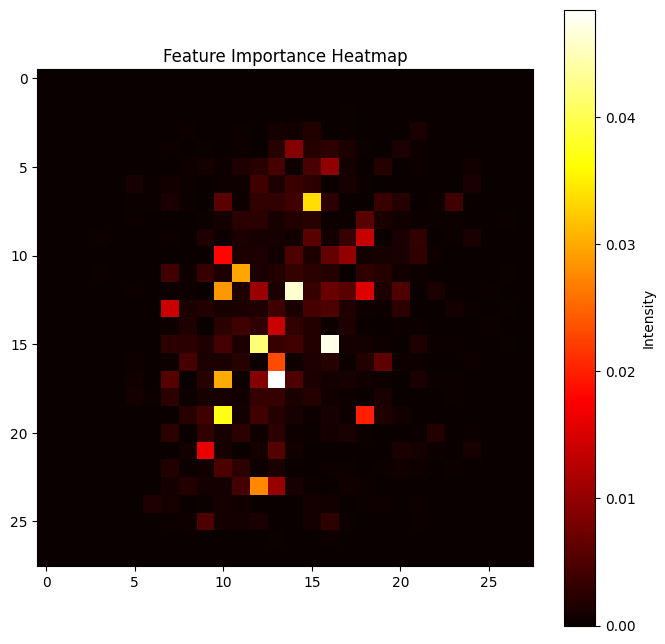

In [56]:
import numpy as np
import matplotlib.pyplot as plt
importances = model.feature_importances_
importances_image = importances.reshape(28, 28)
plt.figure(figsize=(8, 8))
plt.imshow(importances_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('Feature Importance Heatmap')
plt.show()


In [ ]:
#use decision tree and tranformer

# Bringing more in cifar10 and imagenet project

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(28, 28)),  # First LSTM layer
    LSTM(64, return_sequences=True),  # Second LSTM layer
    LSTM(32),  # Third LSTM layer
    Dense(10, activation='softmax')  # Output layer
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xtr,ytr, batch_size=128, epochs=5, validation_split=0.2)
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


In [ ]:
#return_sequences true means - whole sequence will be next passed as input one by one as time steps automatically done..features will be number of neurons for previous lstm layer automatically
#if false - just one input ;use as last lst layer!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##then last dense layer,,can use average local pooling layer of max or globalaverage pooling layer before dense!!

In [ ]:
#understand multi layered lstm-done